# Land-Cover Classification in Waltham Forest (2020 – 2024)  
## Notebook #1 – Pre-processing & Data Export

This notebook

1. fetches the administrative boundary of **Waltham Forest** (Greater London)  
2. authenticates to Google Earth Engine (GEE)  
3. creates *leaf-on* (Apr – Aug) cloud-free **Sentinel-2** composites for each year  
4. exports multi-band GeoTIFFs (B2 – B12 + NDVI + NDBI) to your Google Drive

These GeoTIFFs are the common input for both the *unsupervised K-means* and
*supervised Random-Forest* pipelines developed in later notebooks.

# 1. Setup

In [1]:
# Optional: Environmental Cost Tracking
import time
start_time = time.time()

In [2]:
# Mount Google Drive (comment out if running locally)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# One-time package installs
!pip install -q geopandas shapely geemap==0.17.3 folium rtree eeconvert
!pip install -q earthengine-api rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.7/224.7 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 541.1/541.1 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 75.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.7/94.7 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.9/386.9 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8

In [4]:
# Import Core Libraries
import time, datetime as dt, json, requests, ee, geemap, geopandas as gpd
from pathlib import Path
import geemap.eefolium as geemap
import matplotlib.pyplot as plt

In [5]:
# Define Direcories
ROOT   = Path('/content/drive/MyDrive/Earth Science/GEOL0069/Supervised_vs_Unsupervised_LULC/')
RAW    = ROOT / 'raw'
FIG    = ROOT / 'figures'
DATA   = ROOT / 'data'

for path in [RAW, FIG, DATA]:
    path.mkdir(parents=True, exist_ok=True)

### Authenticate with Google Earth Engine
This notebook uses the Google Earth Engine Python API to fetch and process Sentinel-2 satellite imagery.

**Before running this code**, you need to:
>
> 1. [Sign up for a Google Earth Engine account](https://signup.earthengine.google.com)
>
> 2. [Create a Google Cloud project](https://console.cloud.google.com)
>
> 3. [Enable the Earth Engine API for your project](https://console.developers.google.com/apis/api/earthengine.googleapis.com/overview)
>
> 4. [Register your project with Earth Engine (required for access](https://code.earthengine.google.com/register)

Once those steps are complete, you can run the cell below:

In [6]:
import ee
ee.Authenticate()
ee.Initialize(project='greenbelt-project')    # Replace with your actual project ID if different

# 2. Define and download Area of Interest (AOI)

We request **GBR ADM2** (English local authorities) and extract the polygon
whose `shapeName` equals Waltham Forest.




In [7]:
ISO, ADM = 'GBR', 'ADM2'
gb_url = f"https://www.geoboundaries.org/api/current/gbOpen/{ISO}/{ADM}"
meta   = requests.get(gb_url).json()
geojs  = requests.get(meta['gjDownloadURL']).json()

# Create GeoDataFrame
gdf = gpd.GeoDataFrame.from_features(geojs['features'])

# Assign CRS before transformation
gdf.set_crs('EPSG:4326', inplace=True)

# Filter Waltham Forest and save
wf = gdf[gdf['shapeName'] == 'Waltham Forest'].to_crs('EPSG:4326')
wf_path = RAW / 'waltham_forest.geojson'
wf.to_file(wf_path, driver='GeoJSON')

print('Boundary saved →', wf_path.as_posix())
wf[['shapeName', 'geometry']].head()

Boundary saved → /content/drive/MyDrive/Earth Science/GEOL0069/Supervised_vs_Unsupervised_LULC/raw/waltham_forest.geojson


,shapeName,geometry
122,Waltham Forest,"POLYGON ((-0.04145 51.60563, -0.06118 51.57778..."


## Visual check of AOI

In [8]:
map = geemap.Map(center=[51.6, -0.003], zoom=11)
map.addLayer(ee.FeatureCollection(json.loads(wf.to_json())),
           {'color':'blue'}, 'Waltham Forest')
map

# 3. Data Collection from Earth Engine

In this section, we use the Earth Engine Python API to create and export annual leaf-on composites (April–August) for the Waltham Forest borough.

These composites focus on the leaf-on season, when vegetation is fully active and spectral differences between land cover types (e.g., buildings vs. trees) are most pronounced. This enhances the quality of both unsupervised and supervised classification.

Processing Steps:
- Fetch Sentinel-2 Level-2A surface reflectance imagery (10m resolution)

- Apply a cloud and shadow mask using the Scene Classification Layer (SCL)

- Normalise each band by clipping extreme values (2nd–98th percentile)

- Rescale reflectance bands to a 0–1 range (per-image basis)

- Add NDVI and NDBI indices for vegetation and built-up areas

- Compute median composites for each year (2020–2024)

- Export results to Google Drive (~1–2 mins per year)

These annual composites will serve as the core inputs for both classification pipelines.

## 3.1 Sentinel-2 annual composites for Waltham Forest (2020-2024)


In [9]:
# Define your bands of interest
BANDS = {
    "B2":  "blue",
    "B3":  "green",
    "B4":  "red",
    "B8":  "nir",
    "B11": "swir1",
    "B12": "swir2",
}

# Cloud and shadow masking using SCL band
def mask_s2_scl(img):
    scl = img.select("SCL")
    mask = (scl.neq(3)
              .And(scl.neq(8))
              .And(scl.neq(9))
              .And(scl.neq(10)))
    return (img.updateMask(mask)
              .select(list(BANDS.keys()))
              .rename(list(BANDS.values())))

# Add NDVI and NDBI bands
def add_indices(img):
    ndvi = img.normalizedDifference(["nir", "red"]).rename("NDVI")
    ndbi = img.normalizedDifference(["swir1", "nir"]).rename("NDBI")
    return img.addBands([ndvi, ndbi])

# Dynamically rescale each band to [0, 1] using 2nd–98th percentiles
def per_band_clip_and_rescale(img, lower=2, upper=98):
    def scale_band(band):
        pct = img.select(band).reduceRegion(
            reducer=ee.Reducer.percentile([lower, upper]),
            geometry=ee_wf, scale=10, bestEffort=True)
        lo = ee.Number(pct.get(f'{band}_p{lower}'))
        hi = ee.Number(pct.get(f'{band}_p{upper}'))
        return img.select(band).clamp(lo, hi).subtract(lo).divide(hi.subtract(lo))

    bands = list(BANDS.values())
    scaled = [scale_band(b) for b in bands]
    return ee.Image(scaled).rename(bands)

# Load AOI GeoJSON and convert to EE geometry
with open(RAW / "waltham_forest.geojson") as f:
    wf_geojson = json.load(f)
ee_wf = geemap.geojson_to_ee(wf_geojson).geometry()

# Export normalized composites for each year
for yr in range(2020, 2025):
    print(f"Processing {yr}...")

    # Get clean image collection
    col = (ee.ImageCollection("COPERNICUS/S2_SR")
             .filterBounds(ee_wf)
             .filterDate(f"{yr}-04-01", f"{yr}-08-31")
             .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 10))
             .map(mask_s2_scl)
             .map(lambda im: im.divide(10000))  # SR DN → reflectance
             .map(add_indices))

    # Generate composite
    comp = col.median().clip(ee_wf)
    comp = per_band_clip_and_rescale(comp)  # per-band dynamic rescaling
    comp = add_indices(comp).toFloat()

    # Export to Drive
    task = ee.batch.Export.image.toDrive(
        image=comp,
        description=f"s2_wf_{yr}",
        folder="gee_waltham_forest",
        fileNamePrefix=f"s2_wf_{yr}",
        region=ee_wf,
        scale=10,
        maxPixels=1e13
    )
    task.start()
    print(f"Export launched for {yr}")

# Print task list
print("\nActive Earth Engine tasks:")
for t in ee.batch.Task.list():
    if t.active():
        print("   ", t.id, t.status()["state"], t.config["description"])


Processing 2020...


/usr/local/lib/python3.11/dist-packages/ee/deprecation.py:207: DeprecationWarning: 

Attention required for COPERNICUS/S2_SR! You are using a deprecated asset.
To make sure your code keeps working, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR

  warnings.warn(warning, category=DeprecationWarning)


Export launched for 2020
Processing 2021...
Export launched for 2021
Processing 2022...
Export launched for 2022
Processing 2023...
Export launched for 2023
Processing 2024...
Export launched for 2024

Active Earth Engine tasks:
    E5PNEXUWWLNQJ52X72VPSA7W READY s2_wf_2024
    A57DWENDFITYSMSRHLYBX224 READY s2_wf_2023
    Z4QWC5STC2S3YTSH4XSNSTHT READY s2_wf_2022
    4SVHO7NJJ5MDYSTB6KJDXCVZ READY s2_wf_2021
    2VRESUXCGH2NZD2K74BW7OYY READY s2_wf_2020


## 3.2 Preview the 2024 composite (RGB)

This cell demonstrates how to open a single exported GeoTIFF
and visualise an RGB thumbnail directly in Colab.  
(Adjust the year or the band stretch as you like.)

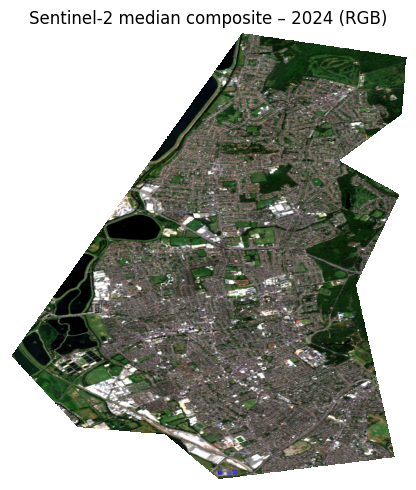

In [10]:
# quicklook
import rasterio
import numpy as np
import matplotlib.pyplot as plt

tif_path = "/content/drive/MyDrive/Earth Science/GEOL0069/Supervised_vs_Unsupervised_LULC/raw/s2_wf_2024.tif"   # adjust year if needed
with rasterio.open(tif_path) as src:
    rgb = src.read([3, 2, 1]).astype("float32")  # red, green, blue bands
rgb = np.clip(rgb, 0, 1)  # no need to rescale again

plt.figure(figsize=(5,5))
plt.imshow(np.moveaxis(rgb, 0, -1))
plt.title("Sentinel-2 median composite – 2024 (RGB)")
plt.axis("off")
plt.tight_layout()
plt.show()

# Enviromental Impact summary

In [11]:
# End timer
end_time = time.time()
duration_sec = end_time - start_time
duration_hr = duration_sec / 3600

# Assumptions
CPU_POWER_W = 20
CARBON_INTENSITY = 0.233  # kg CO₂/kWh (UK grid)
ELECTRICITY_COST = 0.30   # £/kWh (UK average)

# Energy used (kWh) = power (kW) × time (h)
energy_kwh = (CPU_POWER_W / 1000) * duration_hr
co2_kg = energy_kwh * CARBON_INTENSITY
cost_gbp = energy_kwh * ELECTRICITY_COST

# Print results
print(f"Runtime: {duration_hr:.4f} hours")
print(f"Energy used: {energy_kwh:.6f} kWh")
print(f"CO₂ emitted: {co2_kg:.6f} kg CO₂eq")
print(f"Estimated cost: £{cost_gbp:.4f}")

Runtime: 0.0280 hours
Energy used: 0.000560 kWh
CO₂ emitted: 0.000131 kg CO₂eq
Estimated cost: £0.0002
